<h1>Building and Training Siamese Neural Network</h1>

In [1]:
# Local package imports
from src.data_loader import DataSplitter
from src.data_loader.FaceRecognitionDataset import FaceRecognitionDataset
from src.model.FaceNet import SiameseNetwork
from src.trainer.FaceNetTrainer import SiameseNetworkTrainer
from src.utils import mytensorboard
import src.utils.utils_images as img_util

# Pytorch imports 
import torch
import torchvision
from torchsummary import summary

# General imports
import time

<h3>General/Global Variables</h3>

In [2]:
# Paths 
dataset_dir ="./src/data/celeba_dataset/images/"
labels_path="./src/data/celeba_dataset/labels.txt"

# Hyperparameters
batch_size = 4
val_ratio = 0.15
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<h3>Data loading and preprocessing</h3>

In [3]:
print("--------------------------------------------------------------------------")
print("Create dataset...")
dataset = FaceRecognitionDataset(dataset_dir=dataset_dir, labels_path=labels_path)
print(f"Created dataset! Number of samples: {len(dataset)}")
print("--------------------------------------------------------------------------")
print("Split dataset...")
train_dataset, val_dataset = DataSplitter.split_train_test(dataset=dataset, val_ratio=val_ratio)
print(f"Splitted dataset! Number of training samples: {len(train_dataset)}, number of validation samples: {len(val_dataset)}")
print("--------------------------------------------------------------------------")
print("Create data loaders...")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=4,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         num_workers=4)
print(f"Created data loaders! Batch size: {batch_size}")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create dataset...
Created dataset! Number of samples: 70150
--------------------------------------------------------------------------
Split dataset...
Splitted dataset! Number of training samples: 59628, number of validation samples: 10522
--------------------------------------------------------------------------
Create data loaders...
Created data loaders! Batch size: 4
Number of batches in train_loader: 14907
Number of batches in val_loader: 2631
--------------------------------------------------------------------------


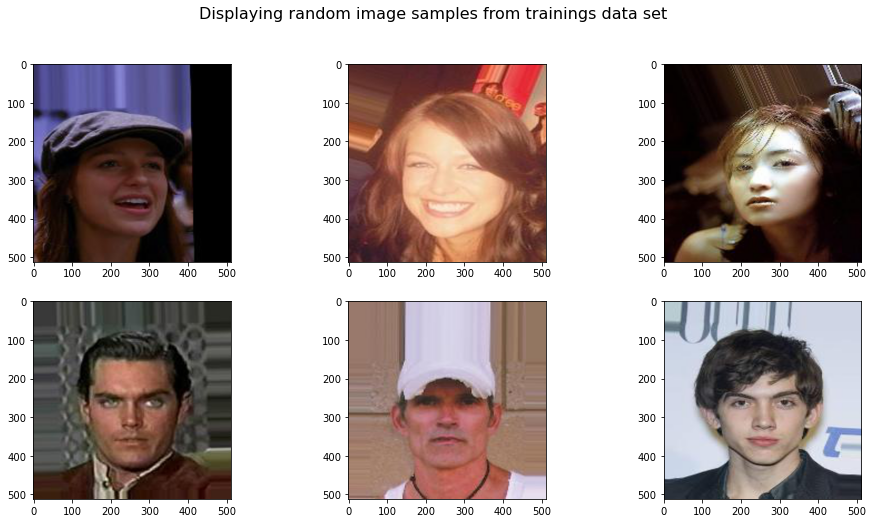

In [4]:
# Random image samples from data set
import matplotlib.pyplot as plt
from PIL import Image

rows, columns = (2, 3)
fig, ax_arr = plt.subplots(rows, columns, figsize=(16,8))
to_pil = torchvision.transforms.ToPILImage()

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        img = to_pil(train_dataset[j+45][0][i])
        ax.imshow(img)

fig.suptitle('Displaying random image samples from trainings data set', fontsize=16)
plt.show() 

<h3>Model building and training</h3>

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
print("--------------------------------------------------------------------------")
print("Create model...")
model = SiameseNetwork().to(device)
print("Created model!")
print(f'Model is on cuda: {next(model.parameters()).is_cuda}')
#print(model)
summary(model, [(3, 512, 512),(3, 512, 512),(3, 512, 512)], batch_size=batch_size)
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create model...
Created model!
Model is on cuda: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [4, 128, 510, 510]           3,584
         MaxPool2d-2         [4, 128, 255, 255]               0
             PReLU-3         [4, 128, 255, 255]             128
            Conv2d-4          [4, 64, 253, 253]          73,792
         MaxPool2d-5          [4, 64, 126, 126]               0
             PReLU-6          [4, 64, 126, 126]              64
            Conv2d-7          [4, 32, 124, 124]          18,464
         MaxPool2d-8            [4, 32, 62, 62]               0
             PReLU-9            [4, 32, 62, 62]              32
           Conv2d-10            [4, 16, 60, 60]           4,624
        MaxPool2d-11            [4, 16, 30, 30]               0
            PReLU-12            [4, 16

In [7]:
print("--------------------------------------------------------------------------")
print("Create tensorboard_writer...")
tensorboard_writer = mytensorboard.MySummaryWriter(numb_batches=len(train_loader), batch_size=batch_size, experiment_name="SiameseNetwork")
print("Created tensorboard_writer!")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create tensorboard_writer...
nonempty logpath
logpath:  ..\logs\SiameseNetwork\run_1(23)
tensorboard is up: http://localhost:6006
Created tensorboard_writer!
--------------------------------------------------------------------------


In [8]:
print("--------------------------------------------------------------------------")
print("Create trainer...")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = SiameseNetworkTrainer(model=model, 
                                train_loader=train_loader,
                                valid_loader=val_loader, 
                                test_loader=val_loader,
                                optimizer=optimizer, 
                                tensorboard_writer=tensorboard_writer)
print("Created trainer!")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create trainer...
Created trainer!
--------------------------------------------------------------------------


<h4>Tensorboard</h4>

In [9]:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# anchors = images[0]
# positives = images[1]
# negatives = images[2]

# # write graph of model to tensorboard
# tensorboard_writer.add_graph(model, images)


# # write sample images to tensorboard


# anchors_grid = torchvision.utils.make_grid(anchors, nrow=batch_size)
# tensorboard_writer.add_image("anchor sample", anchors_grid)

# positives_grid = torchvision.utils.make_grid(positives, nrow=batch_size)
# tensorboard_writer.add_image("positives sample", positives_grid)

# negatives_grid = torchvision.utils.make_grid(negatives, nrow=batch_size)
# tensorboard_writer.add_image("negatives sample", negatives_grid)

# total_grid = torchvision.utils.make_grid([anchors_grid, positives_grid, negatives_grid], nrow=1)
# tensorboard_writer.add_image("sample", total_grid)

# fig = img_util.plot_classes_preds_face_recognition(anchors, labels, ["1234", "1234", "1234", "1234"])
# tensorboard_writer.add_figure("predictions vs. actuals", fig)

# time.sleep(13)

# # Deleting image variables to free RAM
# anchors_grid = None
# positives_grid = None
# negatives_grid = None
# total_grid = None
# fig = None

<h4>Training</h4>

In [10]:
print("start training")

trainer.train(epochs=10)

start training
[0/10][4/14907] => loss: 0.9476070404052734
[0/10][9/14907] => loss: 1.189736008644104
[0/10][14/14907] => loss: 0.9870357513427734
[0/10][19/14907] => loss: 0.9922140836715698
[0/10][24/14907] => loss: 1.3175866603851318
[0/10][29/14907] => loss: 0.9334685206413269
[0/10][34/14907] => loss: 0.9446547031402588
[0/10][39/14907] => loss: 0.9404959082603455
[0/10][44/14907] => loss: 1.0793795585632324
[0/10][49/14907] => loss: 1.1124464273452759
[0/10][54/14907] => loss: 1.2086060047149658
[0/10][59/14907] => loss: 1.1765239238739014
[0/10][64/14907] => loss: 0.8310317993164062
[0/10][69/14907] => loss: 1.0704771280288696
[0/10][74/14907] => loss: 1.0529522895812988
[0/10][79/14907] => loss: 2.1266889572143555
[0/10][84/14907] => loss: 0.9989044666290283
[0/10][89/14907] => loss: 1.0770190954208374
[0/10][94/14907] => loss: 1.1779745817184448
[0/10][99/14907] => loss: 1.3658112287521362
[0/10][104/14907] => loss: 0.9137557744979858
[0/10][109/14907] => loss: 1.0163681507110

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "C:\Users\samii\.conda\envs\applied-ml\lib\site-packages\torch\utils\data\_utils\worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\samii\.conda\envs\applied-ml\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\samii\.conda\envs\applied-ml\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\samii\.conda\envs\applied-ml\lib\site-packages\torch\utils\data\dataset.py", line 272, in __getitem__
    return self.dataset[self.indices[idx]]
  File "C:\Users\samii\Desktop\Universität\Application Challenges for Machine Learning am Beispiel von IBM Power Architecture\Project\src\data_loader\FaceRecognitionDataset.py", line 136, in __getitem__
    image = Image.open(filepath).resize([self.image_width, self.image_height])
  File "C:\Users\samii\.conda\envs\applied-ml\lib\site-packages\PIL\Image.py", line 2891, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: './src/data/celeba_dataset/images\\000000.jpg'


<h3>Model evaluation</h3>